In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
import seaborn as sns
import warnings

In [2]:
# Suppress all warnings

warnings.filterwarnings("ignore")

In [3]:
# Get data source

url = "https://drive.google.com/uc?id=1T2wYkx11DJ0catZivfBqOJgNlpjVUI84&export=download"

In [5]:
# Look at dataframe

df = pd.read_csv(io.StringIO(requests.get(url).text))

# Create a copy of the DataFrame and look at head

df_copy = df.copy()
df_copy.head()

,stay_id,ownership_id,pacaso_id,region,shares_owned,arrival_date,departure_date,stay_type,stay_status,booked_date,cancelled_date
0,9539,681,110,Pacific Southwest,8.0,2021-12-30,2022-03-31,System,Booked,2021-12-29,NaN
1,13477,1039,170,Pacific Southwest,8.0,2022-05-01,2022-05-14,System,Booked,2022-03-29,NaN
2,13476,1039,170,Pacific Southwest,8.0,2022-03-30,2022-04-30,System,Booked,2022-03-29,NaN
3,13478,1039,170,Pacific Southwest,8.0,2022-05-15,2022-05-26,System,Booked,2022-03-29,NaN
4,22143,1039,170,Pacific Southwest,8.0,2023-09-28,2023-10-01,Sales,Cancelled,2022-09-21,2022-09-21


In [7]:
# Look at dimensions of dataframe

df_copy.shape

(24694, 11)

In [8]:
# Look at underlying datatypes

df_copy.dtypes

stay_id             int64
ownership_id        int64
pacaso_id           int64
region             object
shares_owned      float64
arrival_date       object
departure_date     object
stay_type          object
stay_status        object
booked_date        object
cancelled_date     object
dtype: object

In [9]:
# Extract date columns

date_columns = ['arrival_date', 'departure_date', 'booked_date', 'cancelled_date']

In [10]:
# Convert specified columns to datetime

df_copy[date_columns] = df_copy[date_columns].apply(pd.to_datetime, errors='coerce')
print(df_copy.dtypes)

stay_id                    int64
ownership_id               int64
pacaso_id                  int64
region                    object
shares_owned             float64
arrival_date      datetime64[ns]
departure_date    datetime64[ns]
stay_type                 object
stay_status               object
booked_date       datetime64[ns]
cancelled_date    datetime64[ns]
dtype: object


In [11]:
# Look at the number of unique counts

df_copy.nunique()

stay_id           24694
ownership_id        822
pacaso_id            90
region                2
shares_owned          8
arrival_date       1969
departure_date     1976
stay_type             3
stay_status           2
booked_date        1395
cancelled_date     1320
dtype: int64

In [12]:
# Look at the unique values of each column that are not id or dates

print("region:", df_copy['region'].unique())
print("Shares Owned:", df_copy['shares_owned'].unique())
print("Stay Type:", df_copy['stay_type'].unique())
print("Stay Status:", df_copy['stay_status'].unique())

region: ['Pacific Southwest' 'Mountains & Central']
Shares Owned: [ 8. nan  1.  2.  0.  4.  3.  6.  5.]
Stay Type: ['System' 'Sales' 'Pacaso Owner']
Stay Status: ['Booked' 'Cancelled']


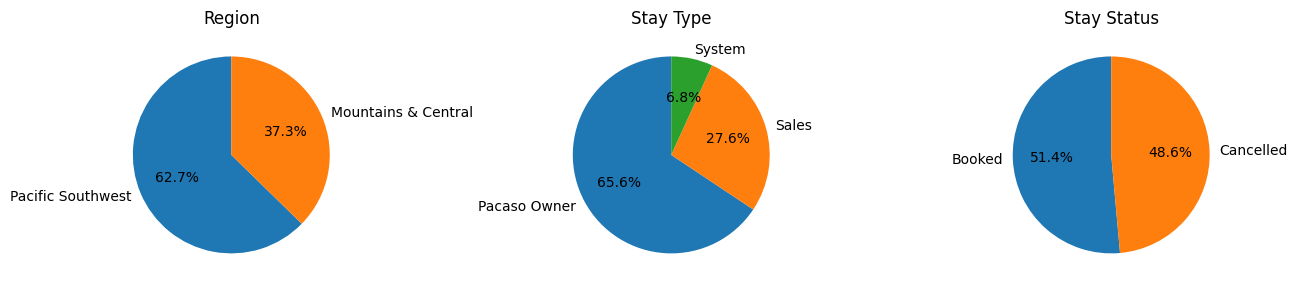

In [13]:
# Define the columns you want to visualize

columns = ['region', 'stay_type', 'stay_status']

# Set up a figure with subplots

fig, axes = plt.subplots(1, len(columns), figsize=(13, 5))  # 1 row, len(columns) columns

# Loop through each column and create a pie chart

for ax, col in zip(axes, columns):
    if df_copy[col].dtype == 'object':
        data = df_copy[col].value_counts()
    else:
        data = df_copy[col].value_counts(bins=5)

    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(col.replace('_', ' ').title())
plt.tight_layout()
plt.show()

In [14]:
# Define the mapping for Shares Owned

shares_owned_mapping = {
    8: "Eight Shares",
    1: "One Share",
    2: "Two Shares",
    0: "No Shares",
    4: "Four Shares",
    3: "Three Shares",
    6: "Six Shares",
    5: "Five Shares",
    float('nan'): "Unknown"  # Handle NaN values if needed
}

# Map Shares Owned to descriptive words

df_copy['shares_owned_words'] = df_copy['shares_owned'].map(shares_owned_mapping)

# Calculate the value counts and percentages

value_counts = df_copy['shares_owned_words'].value_counts(normalize=True) * 100

# Print the percentages in a clear format

print("Shares Owned Percentages:")
for share_type, percentage in value_counts.items():
    print(f"{share_type}: {percentage:.2f}%")

Shares Owned Percentages:
One Share: 63.91%
Unknown: 26.72%
Two Shares: 5.60%
Three Shares: 2.00%
Five Shares: 0.58%
Six Shares: 0.45%
Eight Shares: 0.42%
Four Shares: 0.22%
No Shares: 0.11%


In [15]:
# Look at when the dates start and end

print("Arrival Date Range:", df_copy['arrival_date'].min(), "to", df_copy['arrival_date'].max())
print("Departure Date Range:", df_copy['departure_date'].min(), "to", df_copy['departure_date'].max())
print("Booked Date Range:", df_copy['booked_date'].min(), "to", df_copy['booked_date'].max())
print("Cancelled Date Range:", df_copy['cancelled_date'].min(), "to", df_copy['cancelled_date'].max())

Arrival Date Range: 2021-01-06 00:00:00 to 2029-08-19 00:00:00
Departure Date Range: 2021-01-10 00:00:00 to 2029-09-16 00:00:00
Booked Date Range: 2020-12-09 00:00:00 to 2024-12-23 00:00:00
Cancelled Date Range: 2020-12-16 00:00:00 to 2024-12-23 00:00:00


<h1 style="text-align: center; font-size:30px;">Scheduling Analysis</h1>

Do later co-owners within the same home have different usage patterns than earlier
ones?

In [16]:
# Calculate stay duration

df_copy['stay_duration'] = (df_copy['departure_date'] - df_copy['arrival_date']).dt.days

In [17]:
# Sort by pacaso_id and booked_date to identify order of co-owners

df_copy = df_copy.sort_values(by=['pacaso_id', 'booked_date'])
df_copy

,stay_id,ownership_id,pacaso_id,region,shares_owned,arrival_date,departure_date,stay_type,stay_status,booked_date,cancelled_date,shares_owned_words,stay_duration
6845,588,75,11,Mountains & Central,1.0,2021-02-18,2021-02-21,Pacaso Owner,Booked,2020-12-09,NaT,One Share,3
8379,587,76,11,Mountains & Central,1.0,2021-03-28,2021-04-03,Pacaso Owner,Booked,2020-12-09,NaT,One Share,6
8385,586,76,11,Mountains & Central,1.0,2021-03-04,2021-03-07,Pacaso Owner,Booked,2020-12-09,NaT,One Share,3
6844,591,75,11,Mountains & Central,1.0,2021-06-16,2021-06-21,Pacaso Owner,Booked,2020-12-10,NaT,One Share,5
6850,590,75,11,Mountains & Central,1.0,2022-02-17,2022-02-27,Pacaso Owner,Cancelled,2020-12-10,2021-01-17,One Share,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18732,71663,3875,495,Pacific Southwest,6.0,2025-07-14,2025-07-20,Sales,Booked,2024-12-21,NaT,Six Shares,6
18733,71662,3875,495,Pacific Southwest,6.0,2025-07-07,2025-07-13,Sales,Booked,2024-12-21,NaT,Six Shares,6
18734,71659,3875,495,Pacific Southwest,6.0,2025-05-12,2025-05-18,Sales,Booked,2024-12-21,NaT,Six Shares,6
18716,71705,3875,495,Pacific Southwest,6.0,2025-02-20,2025-02-26,Sales,Booked,2024-12-22,NaT,Six Shares,6


In [18]:
# Assign a rank to ownership_id within each pacaso_id based on booked_date (this assumes that the earliest booked_date is rank 1, and it also assumes all stay_type categories are the same for each pacaso_id)

df_copy['ownership_rank'] = df_copy.groupby('pacaso_id')['booked_date'].rank(method='dense')
df_copy

,stay_id,ownership_id,pacaso_id,region,shares_owned,arrival_date,departure_date,stay_type,stay_status,booked_date,cancelled_date,shares_owned_words,stay_duration,ownership_rank
6845,588,75,11,Mountains & Central,1.0,2021-02-18,2021-02-21,Pacaso Owner,Booked,2020-12-09,NaT,One Share,3,1.0
8379,587,76,11,Mountains & Central,1.0,2021-03-28,2021-04-03,Pacaso Owner,Booked,2020-12-09,NaT,One Share,6,1.0
8385,586,76,11,Mountains & Central,1.0,2021-03-04,2021-03-07,Pacaso Owner,Booked,2020-12-09,NaT,One Share,3,1.0
6844,591,75,11,Mountains & Central,1.0,2021-06-16,2021-06-21,Pacaso Owner,Booked,2020-12-10,NaT,One Share,5,2.0
6850,590,75,11,Mountains & Central,1.0,2022-02-17,2022-02-27,Pacaso Owner,Cancelled,2020-12-10,2021-01-17,One Share,10,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18732,71663,3875,495,Pacific Southwest,6.0,2025-07-14,2025-07-20,Sales,Booked,2024-12-21,NaT,Six Shares,6,4.0
18733,71662,3875,495,Pacific Southwest,6.0,2025-07-07,2025-07-13,Sales,Booked,2024-12-21,NaT,Six Shares,6,4.0
18734,71659,3875,495,Pacific Southwest,6.0,2025-05-12,2025-05-18,Sales,Booked,2024-12-21,NaT,Six Shares,6,4.0
18716,71705,3875,495,Pacific Southwest,6.0,2025-02-20,2025-02-26,Sales,Booked,2024-12-22,NaT,Six Shares,6,5.0


In [19]:
# Define earlier co-owners as those with a lower rank

df_copy['owner_group'] = df_copy['ownership_rank'].apply(lambda x: 'Earlier' if x <= df_copy['ownership_rank'].median() else 'Later')
df_copy

,stay_id,ownership_id,pacaso_id,region,shares_owned,arrival_date,departure_date,stay_type,stay_status,booked_date,cancelled_date,shares_owned_words,stay_duration,ownership_rank,owner_group
6845,588,75,11,Mountains & Central,1.0,2021-02-18,2021-02-21,Pacaso Owner,Booked,2020-12-09,NaT,One Share,3,1.0,Earlier
8379,587,76,11,Mountains & Central,1.0,2021-03-28,2021-04-03,Pacaso Owner,Booked,2020-12-09,NaT,One Share,6,1.0,Earlier
8385,586,76,11,Mountains & Central,1.0,2021-03-04,2021-03-07,Pacaso Owner,Booked,2020-12-09,NaT,One Share,3,1.0,Earlier
6844,591,75,11,Mountains & Central,1.0,2021-06-16,2021-06-21,Pacaso Owner,Booked,2020-12-10,NaT,One Share,5,2.0,Earlier
6850,590,75,11,Mountains & Central,1.0,2022-02-17,2022-02-27,Pacaso Owner,Cancelled,2020-12-10,2021-01-17,One Share,10,2.0,Earlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18732,71663,3875,495,Pacific Southwest,6.0,2025-07-14,2025-07-20,Sales,Booked,2024-12-21,NaT,Six Shares,6,4.0,Earlier
18733,71662,3875,495,Pacific Southwest,6.0,2025-07-07,2025-07-13,Sales,Booked,2024-12-21,NaT,Six Shares,6,4.0,Earlier
18734,71659,3875,495,Pacific Southwest,6.0,2025-05-12,2025-05-18,Sales,Booked,2024-12-21,NaT,Six Shares,6,4.0,Earlier
18716,71705,3875,495,Pacific Southwest,6.0,2025-02-20,2025-02-26,Sales,Booked,2024-12-22,NaT,Six Shares,6,5.0,Earlier


In [20]:
# Aggregate usage patterns for each group

usage_patterns = df_copy.groupby(['pacaso_id', 'owner_group']).agg(
    total_stays=pd.NamedAgg(column='stay_id', aggfunc='count'),
    avg_stay_duration=pd.NamedAgg(column='stay_duration', aggfunc='mean'),
    total_days=pd.NamedAgg(column='stay_duration', aggfunc='sum')
).reset_index()

# Overall summary of earlier vs. later co-owners

overall_summary = usage_patterns.groupby('owner_group').mean()

In [21]:
# Display Usage Patterns by Owner Group (Per Home)

print("Usage Patterns by Owner Group (Per Home):")
print(usage_patterns)

Usage Patterns by Owner Group (Per Home):
     pacaso_id owner_group  total_stays  avg_stay_duration  total_days
0           11     Earlier          130           5.592308         727
1           11       Later          235           6.187234        1454
2           13     Earlier          158           5.348101         845
3           13       Later          232           5.663793        1314
4           20     Earlier          205           5.921951        1214
..         ...         ...          ...                ...         ...
159        329     Earlier          172           6.406977        1102
160        329       Later           58           6.637931         385
161        414     Earlier          134           6.097015         817
162        420     Earlier          172           5.970930        1027
163        495     Earlier           32           6.312500         202

[164 rows x 5 columns]


In [22]:
# Display Overall Summary of Usage Patterns

print("\nOverall Summary of Usage Patterns:")
print(overall_summary)


Overall Summary of Usage Patterns:
              pacaso_id  total_stays  avg_stay_duration   total_days
owner_group                                                         
Earlier      140.244444   138.166667          11.034275   917.344444
Later        117.540541   165.662162           6.440686  1043.337838


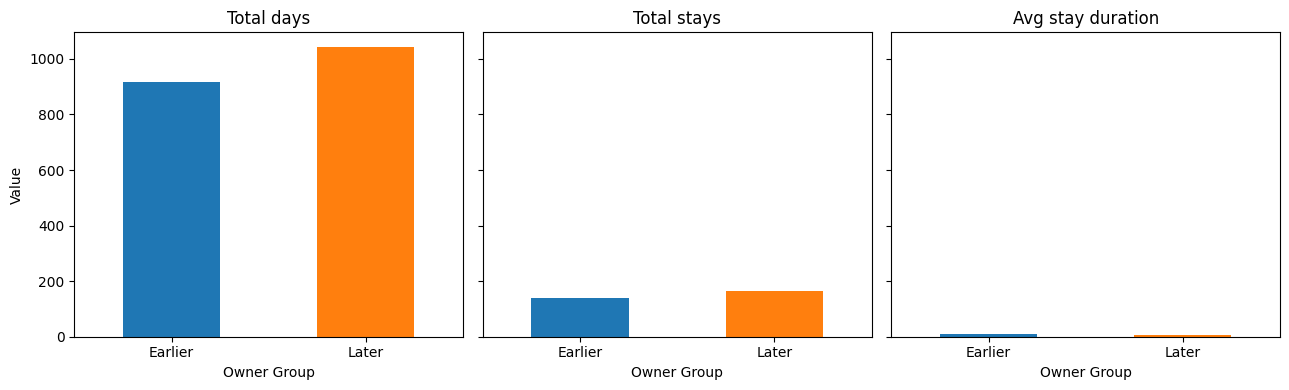

In [23]:
# Create Plot of Total Days Total stays and Average Stay Duration

columns_to_plot = ["total_days", "total_stays", "avg_stay_duration"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), sharey=True)
for i, metric in enumerate(columns_to_plot):
    ax = axes[i]
    overall_summary[metric].plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e"], rot=0)
    ax.set_title(metric.replace("_", " ").capitalize())
    ax.set_xlabel("Owner Group")
    if i == 0:
        ax.set_ylabel("Value")
plt.tight_layout()
plt.show()

In [24]:
# Seasonality Analysis (Chi-Square Test)

df_copy['arrival_month'] = df_copy['arrival_date'].dt.month
contingency_table = df_copy.groupby(['arrival_month', 'owner_group']).size().unstack(fill_value=0)
chi2_stat, chi2_pvalue, chi2_dof, chi2_expected = chi2_contingency(contingency_table)

# Statistical Validation

earlier_stay_durations = df_copy[df_copy['owner_group'] == 'Earlier']['stay_duration'].dropna()
later_stay_durations = df_copy[df_copy['owner_group'] == 'Later']['stay_duration'].dropna()

t_stat, t_pvalue = ttest_ind(earlier_stay_durations, later_stay_durations, equal_var=False)
u_stat, u_pvalue = mannwhitneyu(earlier_stay_durations, later_stay_durations)

In [25]:
# Print only statistical test results

print("\nStatistical Test Results:")
print("1. Chi-Square Test (Seasonality Analysis):")
print(f"   Chi2 Statistic: {chi2_stat:.4f}, P-Value: {chi2_pvalue:.4e}")
print("\n2. T-Test (Stay Durations):")
print(f"   T-Statistic: {t_stat:.4f}, P-Value: {t_pvalue:.4e}")
print("\n3. Mann-Whitney U Test (Stay Durations):")
print(f"   U-Statistic: {u_stat:.4f}, P-Value: {u_pvalue:.4e}")


Statistical Test Results:
1. Chi-Square Test (Seasonality Analysis):
   Chi2 Statistic: 68.9852, P-Value: 1.9039e-10

2. T-Test (Stay Durations):
   T-Statistic: 4.2453, P-Value: 2.1953e-05

3. Mann-Whitney U Test (Stay Durations):
   U-Statistic: 69985842.5000, P-Value: 4.3308e-30


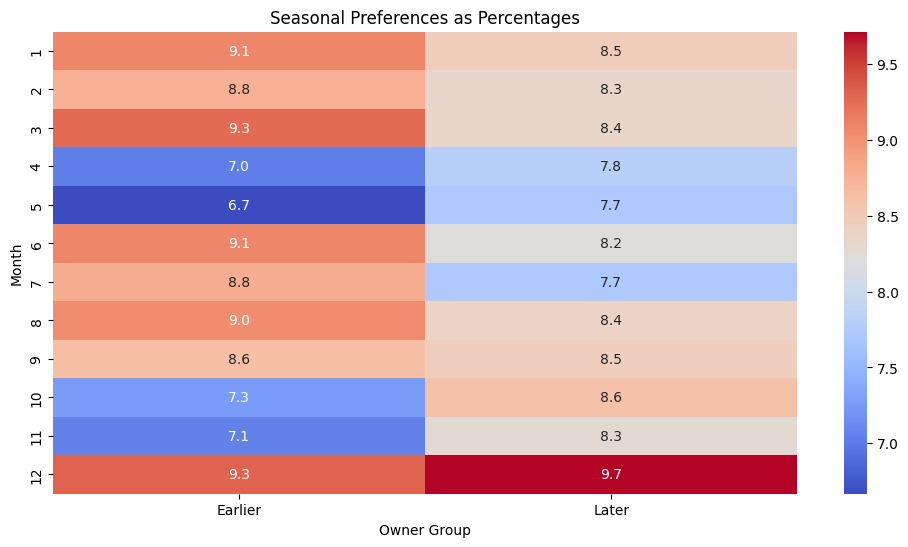

In [26]:
# Plot Seasonal Preferences as Percentages

seasonality = df_copy.groupby(['arrival_month', 'owner_group']).size().reset_index(name='count')
seasonality_pivot = seasonality.pivot(index='arrival_month', columns='owner_group', values='count').fillna(0)
seasonality_pivot_percentage = seasonality_pivot.div(seasonality_pivot.sum(axis=0), axis=1) * 100

# Plot the heatmap

plt.figure(figsize=(12, 6))
sns.heatmap(seasonality_pivot_percentage, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Seasonal Preferences as Percentages')
plt.xlabel('Owner Group')
plt.ylabel('Month')
plt.show()

Typically the end of a Pacaso stay requires a one-day block for cleaning. For example, if
a stay has a Sunday departure, the next possible arrival date would be the following
Monday. If Pacaso moved to same-day turnaround, how much additional calendar
opportunity would this create for co-owners?

In [27]:
# Get a fresh copy of the dataframe

df_copy = df.copy()
df_copy

,stay_id,ownership_id,pacaso_id,region,shares_owned,arrival_date,departure_date,stay_type,stay_status,booked_date,cancelled_date
0,9539,681,110,Pacific Southwest,8.0,2021-12-30,2022-03-31,System,Booked,2021-12-29,NaN
1,13477,1039,170,Pacific Southwest,8.0,2022-05-01,2022-05-14,System,Booked,2022-03-29,NaN
2,13476,1039,170,Pacific Southwest,8.0,2022-03-30,2022-04-30,System,Booked,2022-03-29,NaN
3,13478,1039,170,Pacific Southwest,8.0,2022-05-15,2022-05-26,System,Booked,2022-03-29,NaN
4,22143,1039,170,Pacific Southwest,8.0,2023-09-28,2023-10-01,Sales,Cancelled,2022-09-21,2022-09-21
...,...,...,...,...,...,...,...,...,...,...,...
24689,64201,3739,162,Pacific Southwest,1.0,2025-04-24,2025-04-30,Pacaso Owner,Booked,2024-08-26,NaN
24690,60850,3739,162,Pacific Southwest,1.0,2025-07-29,2025-08-04,Pacaso Owner,Booked,2024-06-25,NaN
24691,63327,3739,162,Pacific Southwest,1.0,2024-08-27,2024-08-29,Pacaso Owner,Booked,2024-08-11,NaN
24692,60316,3739,162,Pacific Southwest,1.0,2024-06-20,2024-06-23,Pacaso Owner,Booked,2024-06-17,NaN


In [28]:
# Convert date columns to datetime format

date_columns = ['arrival_date', 'departure_date']
df_copy[date_columns] = df_copy[date_columns].apply(pd.to_datetime, errors='coerce')

In [29]:
# Sort stays by pacaso_id and departure_date

df_copy = df_copy.sort_values(by=['pacaso_id', 'departure_date'])

In [30]:
# Calculate gaps between stays for each property

df_copy['next_arrival_date'] = df_copy.groupby('pacaso_id')['arrival_date'].shift(-1)
df_copy['gap_days'] = (df_copy['next_arrival_date'] - df_copy['departure_date']).dt.days

In [35]:
# Identify gaps caused by the cleaning block (exactly 1 day)

df_copy['cleaning_gap'] = df_copy['gap_days'] >= 1


In [36]:
# Count the total number of 1-day gaps (potential additional days)

total_cleaning_gaps = df_copy['cleaning_gap'].sum()

In [37]:
# Output total additional calendar opportunities

print(f"Total additional calendar days available under same-day turnaround: {total_cleaning_gaps}")

Total additional calendar days available under same-day turnaround: 11849


In [38]:
# Calculate the additional days per property and sort values for readability

additional_days_per_property = (
    df_copy[df_copy['cleaning_gap']]
    .groupby('pacaso_id')
    .size()
    .reset_index(name='Additional Days')
    .sort_values(by='Additional Days', ascending=False)
)

# Display the top 10 properties with additional days in a readable format

top_10_properties = additional_days_per_property.head(10)
top_10_properties

,pacaso_id,Additional Days
4,27,231
1,13,222
5,28,207
14,62,204
2,20,196
20,72,194
10,41,194
39,112,193
9,39,193
34,98,192


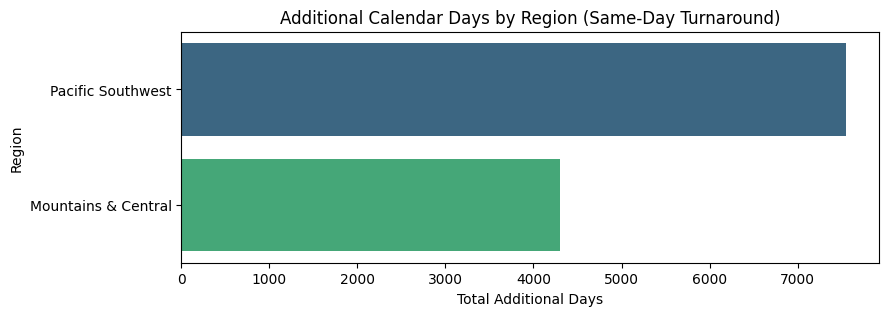

In [39]:
# Analyze additional opportunities by region

region_opportunities = df_copy[df_copy['cleaning_gap']].groupby('region').size().sort_values(ascending=False)


# Bar chart for regions
plt.figure(figsize=(9, 3))
sns.barplot(x=region_opportunities.values, y=region_opportunities.index, palette="viridis")
plt.title("Additional Calendar Days by Region (Same-Day Turnaround)")
plt.xlabel("Total Additional Days")
plt.ylabel("Region")
plt.show()


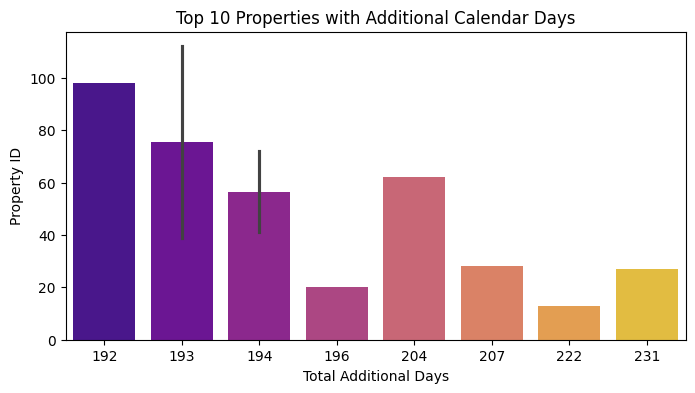

In [40]:
# Summarize additional opportunities by property

property_opportunities = df_copy[df_copy['cleaning_gap']].groupby('pacaso_id').size().sort_values(ascending=False)


# Bar chart for top 10 properties
top_10_properties = property_opportunities.head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_10_properties.values, y=top_10_properties.index, palette="plasma")
plt.title("Top 10 Properties with Additional Calendar Days")
plt.xlabel("Total Additional Days")
plt.ylabel("Property ID")
plt.show()

<h1 style="text-align: center; font-size:30px;">Scheduling Optimization</h1>

How would you design a data science solution for a product feature that predicted future
stay preferences for individual Pacaso co-owners, and proactively suggest available
times they might like to book?

In [65]:
# Create a copy of the DataFrame and look at head

df_copy = df.copy()
df_copy.head()

,stay_id,ownership_id,pacaso_id,region,shares_owned,arrival_date,departure_date,stay_type,stay_status,booked_date,cancelled_date
0,9539,681,110,Pacific Southwest,8.0,2021-12-30,2022-03-31,System,Booked,2021-12-29,NaN
1,13477,1039,170,Pacific Southwest,8.0,2022-05-01,2022-05-14,System,Booked,2022-03-29,NaN
2,13476,1039,170,Pacific Southwest,8.0,2022-03-30,2022-04-30,System,Booked,2022-03-29,NaN
3,13478,1039,170,Pacific Southwest,8.0,2022-05-15,2022-05-26,System,Booked,2022-03-29,NaN
4,22143,1039,170,Pacific Southwest,8.0,2023-09-28,2023-10-01,Sales,Cancelled,2022-09-21,2022-09-21


In [66]:
# Convert dates to datetime format

df_copy['arrival_date'] = pd.to_datetime(df_copy['arrival_date'])
df_copy['departure_date'] = pd.to_datetime(df_copy['departure_date'])

In [67]:
# Calculate stay duration

df_copy['stay_duration'] = (df_copy['departure_date'] - df_copy['arrival_date']).dt.days

In [68]:
# Define high-demand periods

holiday_dict = {
    "Thanksgiving": ["2021-11-25", "2022-11-24", "2023-11-23", "2024-11-21"],
    "Christmas": ["2021-12-25", "2022-12-25", "2023-12-25", "2024-12-25"],
    "New Year's Day": ["2021-01-01", "2022-01-01", "2023-01-01", "2024-01-01"],
    "4th of July": ["2021-07-04", "2022-07-04", "2023-07-04", "2024-07-04"],
    "Spring Break": ["2021-03-15", "2022-03-15", "2023-03-15", "2024-03-15"]
}

In [69]:
# Flatten holiday dates and create a mapping

holiday_dates = []
for holiday_name, dates in holiday_dict.items():
    holiday_dates.extend([(holiday_name, pd.to_datetime(date)) for date in dates])
holiday_df = pd.DataFrame(holiday_dates, columns=['Holiday', 'Date'])

In [70]:
# Function to check which holiday a stay overlaps with

def get_holiday_overlap(arrival, departure):
    if pd.isnull(arrival) or pd.isnull(departure):
        return None
    date_range = pd.date_range(start=arrival, end=departure)
    holidays_in_stay = holiday_df[holiday_df['Date'].isin(date_range)]
    if not holidays_in_stay.empty:
        return holidays_in_stay['Holiday'].iloc[0] 
    return "Non-Holiday"

In [71]:
# Identify stays during specific holidays

df_copy['holiday_overlap'] = df_copy.apply(
    lambda x: get_holiday_overlap(x['arrival_date'], x['departure_date']), axis=1
)

In [72]:
# Replace missing values in stay_duration and shares_owned

df_copy['stay_duration'] = df_copy['stay_duration'].fillna(0)
df_copy['shares_owned'] = df_copy['shares_owned'].fillna(1)

In [73]:
# Aggregate usage by ownership_id and holiday_overlap

grouped = df_copy.groupby(['ownership_id', 'holiday_overlap']).agg(
    total_time=('stay_duration', 'sum'),
    total_stays=('stay_id', 'count')
).reset_index()

In [74]:
# Merge with shares_owned to normalize by ownership

ownership_shares = df_copy[['ownership_id', 'shares_owned']].drop_duplicates()
usage = grouped.merge(ownership_shares, on='ownership_id', how='left')

In [75]:
# Calculate normalized metrics

usage['utilization_ratio'] = usage['total_time'] / usage['shares_owned']

In [76]:
# Step 4: Calculate Gini coefficients

def gini_coeff(x):
    x = np.sort(x)
    n = len(x)
    cumulative_x = np.cumsum(x)
    if cumulative_x[-1] == 0:  # Avoid division by zero
        return 0
    return (n + 1 - 2 * np.sum(cumulative_x) / cumulative_x[-1]) / n

In [77]:
# Filter out invalid or zero shares_owned

usage = usage[usage['shares_owned'] > 0]

In [78]:
# Calculate Gini coefficients for each holiday

gini_results = usage.groupby('holiday_overlap')['utilization_ratio'].apply(gini_coeff).reset_index()
gini_results.columns = ['Holiday', 'Utilization Gini']

In [79]:
# Overall Gini coefficient

overall_gini = gini_coeff(usage['utilization_ratio'].dropna())

In [80]:
# Display results

print("Holiday-Specific Gini Coefficients:")
print(gini_results)
print(f"\nOverall Gini Coefficient for Utilization Ratio: {overall_gini}")

Holiday-Specific Gini Coefficients:
          Holiday  Utilization Gini
0     4th of July          0.437842
1       Christmas          0.419727
2  New Year's Day          0.385974
3     Non-Holiday          0.409073
4    Spring Break          0.463970
5    Thanksgiving          0.608096

Overall Gini Coefficient for Utilization Ratio: 0.6693222832955242


<Figure size 1000x600 with 0 Axes>

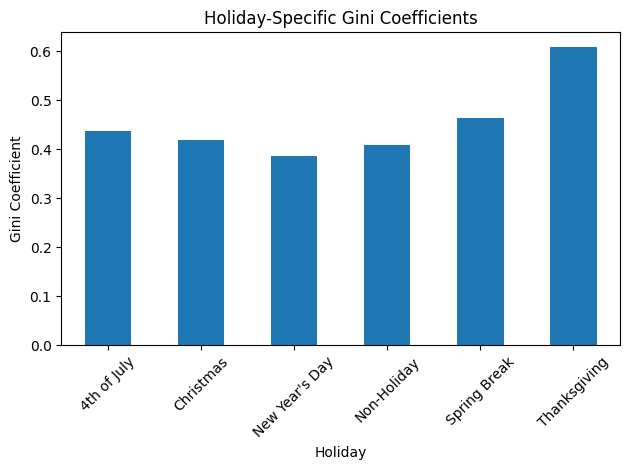

In [81]:
# Visualize Gini Coefficients

plt.figure(figsize=(10, 6))
gini_results.set_index('Holiday').plot(kind='bar', legend=False)
plt.title('Holiday-Specific Gini Coefficients')
plt.ylabel('Gini Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
# Identify Top Users for High-Demand Holidays

top_users = df_copy[df_copy['holiday_overlap'] != "Non-Holiday"].groupby(['holiday_overlap', 'ownership_id']).agg(
    total_time=('stay_duration', 'sum')
).reset_index()

In [83]:
# Calculate the percentage of total time used by each owner during high-demand periods

top_users['percentage_of_time'] = top_users['total_time'] / top_users.groupby('holiday_overlap')['total_time'].transform('sum')

In [84]:
# Sort by percentage within each holiday

top_users = top_users.sort_values(by=['holiday_overlap', 'percentage_of_time'], ascending=[True, False])
print("\nTop Users for High-Demand Holidays:")
print(top_users.head(10))  # Display top 10 users across holidays


Top Users for High-Demand Holidays:
    holiday_overlap  ownership_id  total_time  percentage_of_time
149     4th of July          1086          97            0.023073
174     4th of July          1289          96            0.022835
184     4th of July          1341          92            0.021884
15      4th of July           251          86            0.020457
37      4th of July           408          84            0.019981
43      4th of July           449          66            0.015699
69      4th of July           581          65            0.015461
190     4th of July          1403          62            0.014748
9       4th of July           157          57            0.013559
53      4th of July           498          54            0.012845


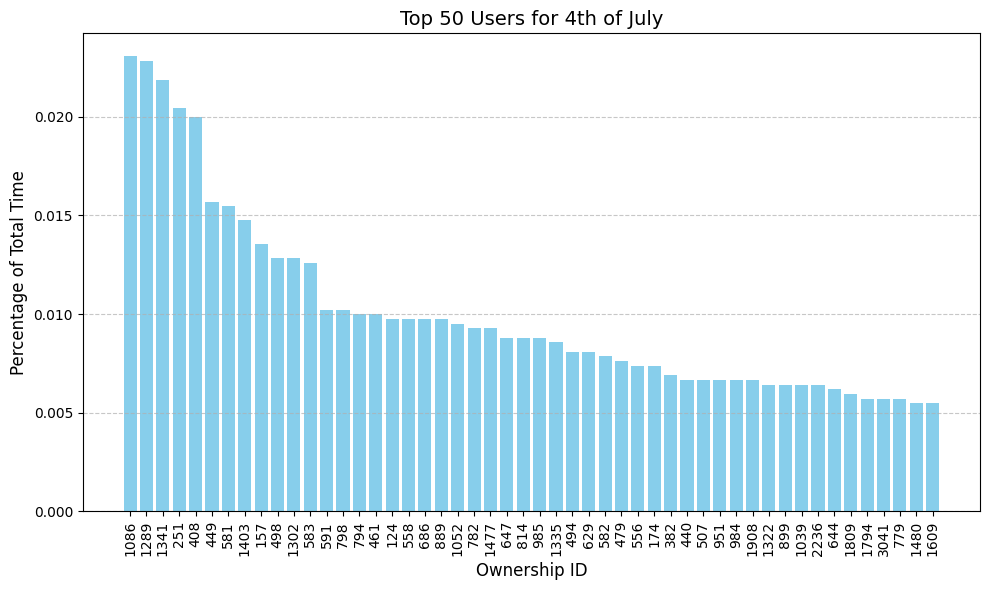

In [85]:
# Visualize Top 200 User Contributions for 4th of July

top_users_4th = top_users[top_users['holiday_overlap'] == '4th of July']

# Sort and limit to top 200 users

top_users_4th_sorted = top_users_4th.sort_values(by='percentage_of_time', ascending=False).head(50)

plt.figure(figsize=(10, 6))
plt.bar(top_users_4th_sorted['ownership_id'].astype(str), top_users_4th_sorted['percentage_of_time'], color='skyblue')
plt.title('Top 50 Users for 4th of July', fontsize=14)
plt.xlabel('Ownership ID', fontsize=12)
plt.ylabel('Percentage of Total Time', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [86]:
# Simulate a policy where high-demand usage is limited to 10% per owner (this is just an example and not a recommendation without further analysis)

policy_limit = 0.1
top_users['adjusted_time'] = top_users['total_time'].where(
    top_users['percentage_of_time'] <= policy_limit, top_users['total_time'] * policy_limit / top_users['percentage_of_time']
)

In [87]:
# Recalculate utilization ratios with the policy applied

adjusted_usage = top_users.groupby('holiday_overlap').agg(
    total_adjusted_time=('adjusted_time', 'sum')
).reset_index()

In [88]:
print("\nAdjusted Usage Under Policy:")
print(adjusted_usage)


Adjusted Usage Under Policy:
  holiday_overlap  total_adjusted_time
0     4th of July               4204.0
1       Christmas               4113.0
2  New Year's Day               2543.0
3    Spring Break               3693.0
4    Thanksgiving               5151.6
